<a href="https://colab.research.google.com/github/Krish-mal15/Brain-Tumor-Segmentation-IGRT-Algorithms/blob/main/3D_Brain_Tumor_Segmentation_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
!pip install opendatasets

In [3]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation//BraTS2020-Data', force=True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Downloading brats20-dataset-training-validation.zip to ./brats20-dataset-training-validation


100%|██████████| 4.16G/4.16G [01:45<00:00, 42.2MB/s]


249
74
45


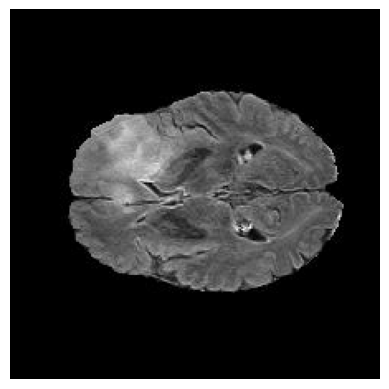

1/1 [==============================] - 0s 133ms/step
Prediction:  [[0.0234426]]
High Grade Glioma


1/1 [==============================] - 0s 492ms/step
Middle coordinate of pixels belonging to class 1 : (8, 19, 65)


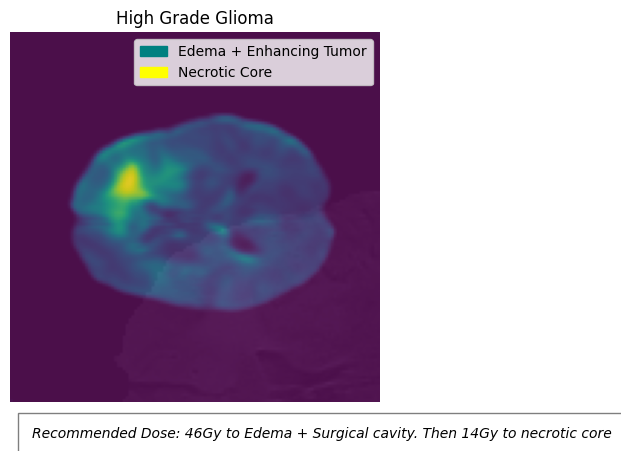

In [7]:
import numpy as np
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.src.layers import Conv3D, Conv3DTranspose, MaxPooling3D, concatenate, ReLU
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from skimage.transform import resize
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import os
from PIL import Image
from keras.preprocessing import image


SEGMENT_CLASSES = {
    0: 'NOT tumor',
    1: 'NECROTIC/CORE',
    2: 'EDEMA',
    3: 'ENHANCING'
}

VOLUME_SLICES = 5
VOLUME_START_AT = 22

IMG_SIZE = 128

train_dir = '/content/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
val_dir = '/content/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/'

# Initial Data Visualization
# test_image_flair=nib.load(train_dir + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
# test_image_t1=nib.load(train_dir + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
# test_image_t1ce=nib.load(train_dir + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
# test_image_t2=nib.load(train_dir + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
# test_mask=nib.load(train_dir + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()
# fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
# slice_w = 25
# ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
# ax1.set_title('Image flair')
# ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
# ax2.set_title('Image t1')
# ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
# ax3.set_title('Image t1ce')
# ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
# ax4.set_title('Image t2')
# ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
# ax5.set_title('Mask')
# plt.show()

train_and_val_directories = [f.path for f in os.scandir(train_dir) if f.is_dir()]


# file BraTS20_Training_355 has ill formatted name for for seg.nii file

train_and_val_directories.remove(train_dir+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0, len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/') + 1:])
    return x


train_and_test_ids = pathListIntoIds(train_and_val_directories)

train_test_ids, val_ids = train_test_split(train_and_test_ids, test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids, test_size=0.15)


class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=3, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):

        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        Batch_ids = [self.list_IDs[k] for k in indexes]

        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):

        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))
        Y = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim))

        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(train_dir, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii')
            flair = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t1ce.nii')
            ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t2.nii')
            t2 = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_seg.nii')
            seg = nib.load(data_path).get_fdata()

            slice_w = 25

            for j in range(VOLUME_SLICES):
                X[j + VOLUME_SLICES * c, :, :, :, 0] = cv2.resize(flair[:, :, flair.shape[0] // 2 - slice_w + j],
                                                                  (IMG_SIZE, IMG_SIZE))
                X[j + VOLUME_SLICES * c, :, :, :, 1] = cv2.resize(ce[:, :, ce.shape[0] // 2 - slice_w + j],
                                                                  (IMG_SIZE, IMG_SIZE))
                X[j + VOLUME_SLICES * c, :, :, :, 2] = cv2.resize(t2[:, :, t2.shape[0] // 2 - slice_w + j],
                                                                  (IMG_SIZE, IMG_SIZE))
                Y[j + VOLUME_SLICES * c, :, :, :] = cv2.resize(seg[:, :, seg.shape[0] // 2 - slice_w + j],
                                                               (IMG_SIZE, IMG_SIZE))

        Y[Y == 4] = 3
        mask = tf.one_hot(Y, 4)

        return X / np.max(X), mask


training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

print(len(train_ids))
print(len(val_ids))
print(len(test_ids))

# def dice_coef(y_true, y_pred, smooth=1.0):
#     class_num = 4
#     for i in range(class_num):
#         y_true_f = K.flatten(y_true[:, :, :, :, i])
#         y_pred_f = K.flatten(y_pred[:, :, :, :, i])
#         intersection = K.sum(y_true_f * y_pred_f)
#         loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
#         #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
#         if i == 0:
#             total_loss = loss
#         else:
#             total_loss = total_loss + loss
#
#     total_loss = total_loss / class_num
#     #    K.print_tensor(total_loss, message=' total dice coef: ')
#     return total_loss
#
#
# # define per class evaluation of dice coef
# # inspired by https://github.com/keras-team/keras/issues/9395
# def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
#     intersection = K.sum(K.abs(y_true[:, :, :, :, 1] * y_pred[:, :, :, :, 1]))
#     return (2. * intersection) / (
#                 K.sum(K.square(y_true[:, :, :, :, 1])) + K.sum(K.square(y_pred[:, :, :, 1])) + epsilon)
#
#
# def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
#     intersection = K.sum(K.abs(y_true[:, :, :, :, 2] * y_pred[:, :, :, :, 2]))
#     return (2. * intersection) / (
#                 K.sum(K.square(y_true[:, :, :, :, 2])) + K.sum(K.square(y_pred[:, :, :, 2])) + epsilon)
#
#
# def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
#     intersection = K.sum(K.abs(y_true[:, :, :, :, 3] * y_pred[:, :, :, :, 3]))
#     return (2. * intersection) / (
#                 K.sum(K.square(y_true[:, :, :, :, 3])) + K.sum(K.square(y_pred[:, :, :, 3])) + epsilon)
#
#
# # Computing Precision
# def precision(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     return precision
#
#
# # Computing Sensitivity
# def sensitivity(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     return true_positives / (possible_positives + K.epsilon())
#
#
# # Computing Specificity
# def specificity(y_true, y_pred):
#     true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
#     possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
#     return true_negatives / (possible_negatives + K.epsilon())


# def unet(inputs, ker_init):
#     s = inputs

#     # Contraction path
#     c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(s)
#     c1 = Dropout(0.1)(c1)
#     c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c1)
#     p1 = MaxPooling3D((2, 2, 2))(c1)

#     c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(p1)
#     c2 = Dropout(0.1)(c2)
#     c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c2)
#     p2 = MaxPooling3D((2, 2, 2))(c2)

#     c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(p2)
#     c3 = Dropout(0.2)(c3)
#     c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c3)
#     p3 = MaxPooling3D((2, 2, 2))(c3)

#     c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(p3)
#     c4 = Dropout(0.2)(c4)
#     c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c4)
#     p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)

#     c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(p4)
#     c5 = Dropout(0.3)(c5)
#     c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c5)

#     # Expansive path
#     u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
#     u6 = concatenate([u6, c4])
#     c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(u6)
#     c6 = Dropout(0.2)(c6)
#     c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c6)

#     u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
#     u7 = concatenate([u7, c3])
#     c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(u7)
#     c7 = Dropout(0.2)(c7)
#     c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c7)

#     u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
#     u8 = concatenate([u8, c2])
#     c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(u8)
#     c8 = Dropout(0.1)(c8)
#     c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c8)

#     u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
#     u9 = concatenate([u9, c1])
#     c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(u9)
#     c9 = Dropout(0.1)(c9)
#     c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c9)

#     outputs = Conv3D(4, (1, 1, 1), activation='softmax')(c9)

#     model = Model(inputs=[inputs], outputs=[outputs])

#     return model


# input_layer = Input((IMG_SIZE, IMG_SIZE, IMG_SIZE, 3))
# model = unet(input_layer, 'he_normal')
# model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#               metrics=['accuracy'])

# model.summary()

# history = model.fit(training_generator,
#                     epochs=15,
#                     steps_per_epoch=len(train_ids),
#                     validation_data = valid_generator
#                     )
# model.save('/model/Tumor-Segment3d-Model.keras')

grade_model = keras.models.load_model('/content/glioma-grade.keras')

model = keras.models.load_model('/content/Tumor-Segment3d-Model.keras')

path = '/content/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_030/BraTS20_Training_030_flair.nii'
input_img = nib.load(path)
input_data = input_img.get_fdata()

slice_number = 69

# Retrieve the slice
slice_data = input_data[:, :, slice_number]

slice_data = (slice_data - slice_data.min()) / (slice_data.max() - slice_data.min()) * 255
slice_data = slice_data.astype('uint8')

# Convert the slice data to a PIL image
slice_img = Image.fromarray(slice_data)

# Save the slice image as a JPG file
slice_img.save('/content/slice_69.jpg'.format(slice_number))

def load_image(img_path, show=True, predictions=''):

    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.

    if show:
        plt.imshow(img_tensor[0])
        plt.axis('off')
        plt.title(predictions)
        plt.show()

    return img_tensor

img_path = '/content/slice_69.jpg'

new_image = load_image(img_path)

pred1 = grade_model.predict(new_image)
print('Prediction: ', pred1)


if pred1[0][0] <= 0.5:
    print("High Grade Glioma")
    grade = 'High Grade Glioma'
    dose = 'Recommended Dose: 46Gy to Edema + Surgical cavity. Then 14Gy to necrotic core'
else:
    print("Low Grade Glioma")
    grade = 'Low Grade Glioma'
    dose = 'Recommended Dose: 50Gy at 1.8Gy per fraction'



# Resize the input data to match the expected input shape of your model
desired_shape = (128, 128, 128)
resized_input_data = resize(input_data, desired_shape, anti_aliasing=True)

# Add an empty channel dimension to match the expected input shape
resized_input_data_with_channel = np.expand_dims(resized_input_data, axis=-1)

# Repeat the channel dimension to match the expected number of channels (3)
resized_input_data_with_channels = np.repeat(resized_input_data_with_channel, 3, axis=-1)

# Preprocess the resized input data (normalize, etc.) if needed
# Replace this with your own preprocessing code as needed
# Example preprocessing: normalization to [0, 1] range
resized_input_data_with_channels = (resized_input_data_with_channels - np.min(resized_input_data_with_channels)) / (np.max(resized_input_data_with_channels) - np.min(resized_input_data_with_channels))

# Make predictions
predictions = model.predict(np.expand_dims(resized_input_data_with_channels, axis=0))  # Assuming batch size of 1

desired_class = 1  # Change this to the class you are interested in

# Find the indices where the predicted mask matches the desired class
indices = np.where(predictions[0] == desired_class)

# Get the coordinates from the indices
coordinates = list(zip(indices[2], indices[1], indices[0]))  # Reversed due to different order of dimensions

# Find the middle coordinate
if len(coordinates) > 0:
    middle_coordinate = coordinates[len(coordinates) // 2]
    print("Middle coordinate of pixels belonging to class", desired_class, ":", middle_coordinate)
else:
    print("No pixels belonging to class", desired_class)
# Save the prediction masks to a NIfTI file
prediction_img = nib.Nifti1Image(predictions[0], input_img.affine)
nib.save(prediction_img, 'prediction_mask_new_val.nii')

original_img = nib.load(path)
original_data = original_img.get_fdata()

# Load the predicted mask
prediction_mask = nib.load('/content/prediction_mask_new_val.nii')
prediction_data = prediction_mask.get_fdata()

# Normalize original data for visualization
original_data = (original_data - np.min(original_data)) / (np.max(original_data) - np.min(original_data))

# Plot the original image
plt.imshow(original_data[:, :, original_data.shape[2] // 2], cmap='gray')

# Overlay the predicted mask with transparency
alpha = 0.5  # Transparency level
for class_index in range(prediction_data.shape[-1]):
    class_mask = prediction_data[..., class_index]
    plt.imshow(class_mask[:, :, class_mask.shape[2] // 2], alpha=alpha)

plt.axis('off')
plt.title(grade)
plt.text(7, 140, dose, style='italic',
        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})
color_patch = mpatches.Patch(color='yellow', label='Necrotic Core')
edema = mpatches.Patch(color='teal', label='Edema + Enhancing Tumor')

plt.legend(handles=[edema, color_patch])
plt.show()


In [ ]:
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)

2.15.0
2.15.0
